<a href="https://colab.research.google.com/github/AlenZhang-Dev/Learning-Records/blob/master/Machine%20Learning/Deep%20Learning%20with%20Python/5.3%20%E4%BD%BF%E7%94%A8%E9%A2%84%E8%AE%AD%E7%BB%83%E7%9A%84%E5%8D%B7%E7%A7%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount the drive to colab notebook
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 使用预训练的卷积神经网络
使用深度学习对小型图像数据集进行训练，一种比较高效的方法是使用预训练网络。预训练网络指已经保存好的网络，之前在一个大型网络中训练好，如果这个原始数据足够大而且足够通用，那么预训练网络学到的特征的空间层次结构可以有效作为视觉领域的模型。使用预训练网络有两种方法：特征提取(feature extraction)和微调模型(fine-tuning)。

本例中，我们使用VGG16模型进行训练。
> VGG模型相对而言是一个比较旧的模型，性能比不了当前最陷阱的模型，且比许多新模型复杂。
选择VGG是因为其使用的架构与我们熟悉的架构类型。




# 特征提取
特征提取指使用之前网络学到的表示来从新样本中提取有趣的特征，然后将这些特性输入一个新的分类器，进行重新训练。在卷积神经网络中我们使用原先的卷积基，因为卷积基学到的特征更加通用，适合重复使用。某个卷积层提取的表示的通用性取决于该层在模型中的深度。模型中靠近地步的层提取的是局部的，高度通用的特征图【比如视觉边缘，颜色和纹理】。而靠近顶层的是更加抽象的概念【猫耳朵，狗眼睛】。如果你的新数据集和原始模型训练数据集有很大的差异，最好使用模型的前几层进行特征提取，而不是使用整个卷积基。



## 实例化VGG16卷积模型

向构造函数中传入三个参数

*   weights 指定模型初始化的权重检查点
*   include_top 指定模型最后是否包含密集连接分类器。默认情况下，该密集连接层对应ImageNet的1000个类别。因为我们打算使用自己的密集连接分类器（只有Dog和cat）所以不需要包含它。
*   input_shape 指输入到网络中的图像张量的形状，这个参数完全是自己可选的，如果不传这个参数，那么这个网络能够处理任意形状输入。



In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

最终的特征图形状为（4, 4, 512)，我们将在这个特征上添加一个密集连接分类器。

## 方法一：不使用数据增强的快速特征提取
首先，运行ImageDataGenerator实例，将图像及其标签提取为Numpy数组。我们需要调用conv_base模型的predict方法来从这些图像中提取特征。
以下为在数据集上运行卷积基，将输出保存成硬盘中的Numpy数组，然后用这个数组作为输入，输入到独立的密集连接分类器中。

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/gdrive/My Drive/Kaggle/dogs-vs-cats/dogs-vs-cats-small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


目前提取特征形状为（samples，4，4，512）我们要将其输入到密集连接分类器中，首先将其形状展平为（samples，8192）

In [4]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

现在可以定义并训练密集连接分类器，过程很快，因为只需要处理两个Dense层



In [5]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
100/100 [==============================] - 1s 5ms/step - loss: 0.5977 - acc: 0.6700 - val_loss: 0.4330 - val_acc: 0.8450
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4235 - acc: 0.8075 - val_loss: 0.3598 - val_acc: 0.8550
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3515 - acc: 0.8560 - val_loss: 0.328

训练可视化

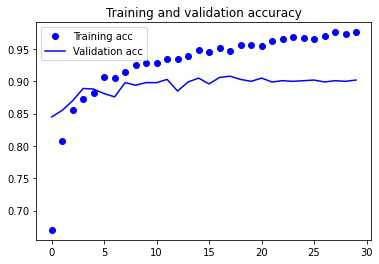

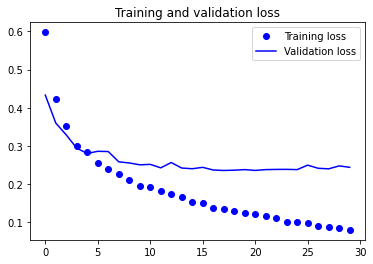

In [6]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

总结：验证精度达到90%左右，比上一节从头开始训练的小型模型效果要好很多。但从图中可以看出，虽然dropout比率相对较大，但模型几乎从一开始就过拟合。这是因为该方法无法使用数据增加，而数据增强对于防止小型图像数据集的过拟合非常重要。

## 方法二：使用数据增强的特征提取
该方法速度更慢，计算代价更高，但在训练期间可以使用数据增强。该方法就是：扩展conv_base模型，然后在输入数据上端到端运行模型。

In [7]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


可见VGG16的卷积积参数非常多，在编译和训练模型之前，一定要“冻结”卷积核，冻结一个或多个层是指在训练过程中保持权重不变。如果不这么做，那么卷积基之前学到的表示将会在训练过程中被修改，因为其上添加的Dense层是随机初始化的，所以非常大的权重会在网络中传播，对先验知识得到很大的破坏。

利用冻结的卷积基端到端训练模型

In [8]:
conv_base.trainable = False

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
100/100 - 24s - loss: 0.5900 - acc: 0.6935 - val_loss: 0.4858 - val_acc: 0.7460
Epoch 2/30
100/100 - 23s - loss: 0.4814 - acc: 0.7850 - val_loss: 0.3958 - val_acc: 0.8340
Epoch 3/30
100/100 - 23s - loss: 0.4359 - acc: 0.8050 - val_loss: 0.3386 - val_acc: 0.8710
Epoch 4/30
100/100 - 23s - loss: 0.4131 - acc: 0.8175 - val_loss: 0.3122 - val_acc: 0.8700
Epoch 5/30
100/100 - 22s - loss: 0.3903 - acc: 0.8300 - val_loss: 0.2926 - val_acc: 0.8850
Epoch 6/30
100/100 - 22s - loss: 0.3739 - acc: 0.8395 - val_loss: 0.2935 - val_acc: 0.8810
Epoch 7/30
100/100 - 23s - loss: 0.3672 - acc: 0.8380 - val_loss: 0.2773 - val_acc: 0.8870
Epoch 8/30
100/100 - 23s - loss: 0.3568 - acc: 0.8425 - val_loss: 0.2715 - val_acc: 0.8860
Epoch 9/30
100/100 - 22s - loss: 0.3445 - acc: 0.8520 - val_loss: 0.2701 - val_acc: 0.8860
Epoch 10/30
100/100 -

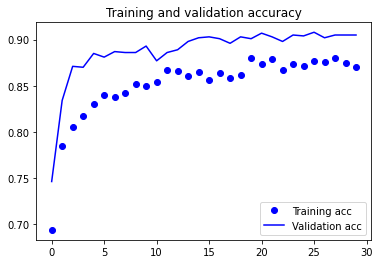

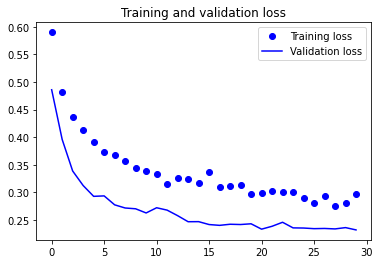

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 进一步优化：微调模型（fune-tuning）
该方法与特征提取相互补充。微调指将顶部的几层解冻，并将这几层和新增加的部分联合训练。
前文讲过：冻结VGG卷积基是为了能够在上面训练一个随机初始化的分类器。因此只有上面的分类器训练好了，才能微调卷积层的顶部几层。如果分类器都没有训练好，那么训练期间通过网络传播的误差信号会特别大。微调前几层之前学到的表示都会被破坏。

微调网络的步骤如下
1. 在训练好的基网络上添加自定义网络。
2. 冻结基网络
3. 训练所添加的部分
4. 解冻基网络的一次层。
5. 联合训练解冻这些层和添加的部分。

我们在做特征提取时已经完成了前三个步骤。我们继续第四步：先解冻conv_base,然后冻结其中的部分层。

冻结直到某一层的所有层


In [11]:
conv_base.summary()

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

现在我们可以微调网络。我们将使用学习率非常小的RMSProp优化器实现。之所以学习速率小，是因为对于微调的三层表示，我们希望变化范围不要太大。太大的权重更新可能会破坏这些表示。

微调模型

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 22s 223ms/step - loss: 0.2890 - acc: 0.8790 - val_loss: 0.2352 - val_acc: 0.9060
Epoch 2/100
100/100 [==============================] - 22s 223ms/step - loss: 0.2443 - acc: 0.8905 - val_loss: 0.2267 - val_acc: 0.9010
Epoch 3/100
100/100 [==============================] - 23s 230ms/step - loss: 0.2265 - acc: 0.9035 - val_loss: 0.2136 - val_acc: 0.9150
Epoch 4/100
100/100 [==============================] - 22s 220ms/step - loss: 0.2210 - acc: 0.9070 - val_loss: 0.1903 - val_acc: 0.9300
Epoch 5/100
100/100 [==============================] - 22s 220ms/step - loss: 0.2196 - acc: 0.9090 - val_loss: 0.1981 - val_acc: 0.9290
Epoch 6/100
100/100 [==============================] - 22s 220ms/step - loss: 0.1899 - acc: 0.9205 - val_loss: 0.1868 - val_acc: 0.9270
Epoch 7/100
100/100 [==============================] - 23s 226ms/step - loss: 0.1867 - acc: 0.9315 - val_loss: 0.2620 - val_acc: 0.9070
Epoch 8/100
100/100 [===========================

训练数据




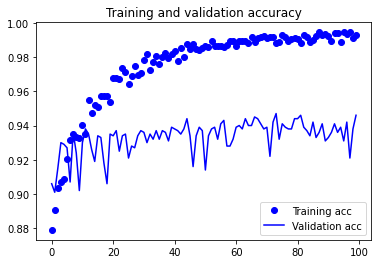

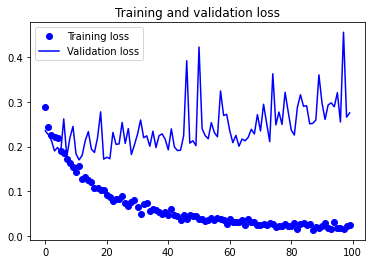

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

在测试数据上最终评估这个模型

In [14]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
test acc: 0.9340000152587891


## 模型保存
将模型保存到Google Drive中，需要先挂在Drive，然后指定挂在路径即可。

In [15]:
!pip install pyyaml h5py

In [24]:

model.save('gdrive/MyDrive/saved_model/cats_and_dogs_small_3.h5')


# 总结
* 卷积神经网络是用于计算机视觉任务的最佳及其学习模型。即使在非常小的数据集上也可以从头开始训练一个卷积神经网络，且得到不错的结果。
* 在小型数据集上主要问题是过拟合，在处理图像数据时，数据增强是一种降低过拟合的强大方法。
* 利用特征提取，可以很容易将现有的卷积神经网络复用于新数据集，对于小型图像数据集，是一种很有价值的方法。
* 作为特征提取的补充，可以使用微调整进一步提高模型的性能。